In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bilby
import pandas as pd
import dynesty
import joblib
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from matplotlib.colors import LogNorm
import multiprocessing
import corner as corner
from dynesty.utils import resample_equal
import healpy as hp

In [2]:
duration = 4
sampling_frequency = 2048
t0_gps = 1126259460.4
n_samples = duration*sampling_frequency
time = np.linspace(0, duration, n_samples)

delta = 5
ras = np.radians(np.arange(0, 360, delta))
decs = np.radians(np.arange(-90, 90, delta))
ra_s = np.radians(np.linspace(-180, 180, len(ras)+1))
dec_s = np.radians(np.linspace(-90, 90, len(decs)+1))
radec_s = np.array([(ra, dec) for ra in ra_s for dec in dec_s])
radec = np.array([(ra, dec) for ra in ras for dec in decs])
radec_map = radec.reshape(36, 72, 2)

In [3]:
data = joblib.load('data/data.pkl')

In [4]:
IFOH = bilby.gw.detector.InterferometerList(['H1'])[0]
IFOH.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['h1_psd']['Hz'], psd_array=data['h1_psd']['PSD'])
# IFOH.frequency_array = h1_psd['Hz']

IFOL = bilby.gw.detector.InterferometerList(['L1'])[0]
IFOL.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['l1_psd']['Hz'], psd_array=data['l1_psd']['PSD'])
# IFOL.frequency_array = l1_psd['Hz']

IFOV = bilby.gw.detector.InterferometerList(['V1'])[0]
IFOV.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(frequency_array=data['v1_psd']['Hz'], psd_array=data['v1_psd']['PSD'])
# IFOV.frequency_array = v1_psd['Hz']

In [5]:
def priors(params):
    ra, dec, psi, tc_geo, dl = params
    return np.array([ra*2*np.pi, np.arcsin(2*dec-1), psi*np.pi, tc_geo*4, 1e-4*(1000/1e-3)**dl])

def log_likelihood(params):
    ra, dec, psi, tc_geo, DL = params
    
    logl = 0

    for strain, IFO in zip(strains, IFOS):
        asd = IFO.power_spectral_density.asd_array
        asd[~mask] = np.inf
        fplus = IFO.antenna_response(ra=ra, dec=dec, time=t0_gps, psi=psi, mode='plus')
        fcross = IFO.antenna_response(ra=ra, dec=dec, time=t0_gps, psi=psi, mode='cross')
        template = data['waveform']['h+'] * fplus + data['waveform']['hx'] * fcross
        delay = tc_geo + IFO.time_delay_from_geocenter(ra, dec, t0_gps)
        phase_shift = np.exp(-1j * 2*np.pi * data['waveform']['Hz'] * delay)
        h = template * phase_shift
        h /= DL
        res = strain['h'] - h
        logl -= 2 * np.sum(((res * np.conj(res)) / asd**2) * df)

    return logl.real

def plot_corner(sampler, flag):
    result = sampler.results
    samples = result.samples
    weights = np.exp(result.logwt - result.logz[-1])
    equal_samples = resample_equal(samples, weights)
    psi_samples = equal_samples[:, 2]
    psi_centered = (psi_samples + np.pi/2) % np.pi - np.pi/2
    equal_samples[:, 2] = psi_centered

    fig = corner.corner(
        equal_samples,
        labels=[r"$\alpha$", r"$\delta$", r"$\psi$", r"$t_c^{geo}$", r"$D_L$"],
        quantiles=[0.05, 0.5, 0.95],
        show_titles=True,
        title_kwargs={"fontsize": 17},
        title_fmt='.3f',
        color='blue',
        label_kwargs={"fontsize": 17},
        labelpad=0.1,
    )

    for ax in fig.axes:
        ax.tick_params(axis='both', which='major', labelsize=14)  

    plt.savefig(f'figures/corner_{flag}.png', dpi=300, bbox_inches='tight')

    return equal_samples

def plot_map(equal_samples, flag):
    ra_samples = equal_samples[:, 0]
    dec_samples = equal_samples[:, 1]

    nside = 64

    theta = np.pi/2 - dec_samples
    phi = ra_samples

    pixels = hp.ang2pix(nside, theta, phi)

    prob_map = np.bincount(pixels, minlength=hp.nside2npix(nside))
    prob_map = prob_map / prob_map.sum()

    prob_map = hp.smoothing(prob_map, fwhm=np.radians(1.0))

    hp.newvisufunc.projview(prob_map, 
                            coord=["C"],
                            graticule=True, 
                            graticule_labels=True,
                            projection_type="mollweide",
                            xlabel="RA",
                            ylabel="Dec",
                            latitude_grid_spacing=30,
                            cb_orientation="vertical",
                            cmap='viridis_r'
                            )
    # hp.graticule()

    max_idx = np.argmax(prob_map)
    max_theta, max_phi = hp.pix2ang(nside, max_idx)
    max_dec = np.pi/2 - max_theta
    max_ra = max_phi

    max_ra_deg = np.rad2deg(max_ra)
    max_dec_deg = np.rad2deg(max_dec)
    print(f"Most probable location: RA = {max_ra_deg:.2f} deg, Dec = {max_dec_deg:.2f} deg")

    max_ra_wrapped = max_ra_deg if max_ra_deg <= 180 else max_ra_deg - 360

    hp.newvisufunc.newprojplot(max_ra_wrapped, max_dec_deg, 'ro', lonlat=True, markersize=2)

    plt.savefig(f"figures/posterior_map_{flag}.png")
    plt.show()

In [6]:
IFOS = [IFOH, IFOL]#, IFOV]
strains = [data['h1_strain'], data['l1_strain']]#, data['v1_strain']]
mask = data['waveform']['Hz'] > 20
df = data['waveform']['Hz'][1] - data['waveform']['Hz'][0]

In [7]:
sampler = dynesty.DynamicNestedSampler(
    log_likelihood,
    priors,
    ndim=5,
    nlive=1000,    
    bound="multi", 
    sample="rwalk",
    queue_size=multiprocessing.cpu_count(),
    pool=multiprocessing.Pool(processes=multiprocessing.cpu_count()),
    periodic=[0,2],
    rstate=np.random.default_rng(seed=441),
)
sampler.run_nested(dlogz_init=0.01, print_progress=True)

34669it [01:34, 367.54it/s, batch: 2 | bound: 3 | nc: 1 | ncall: 770680 | eff(%):  4.363 | loglstar: -7898.868 < -7894.729 < -7898.254 | logz: -7919.435 +/-  0.128 | stop:  0.893]       


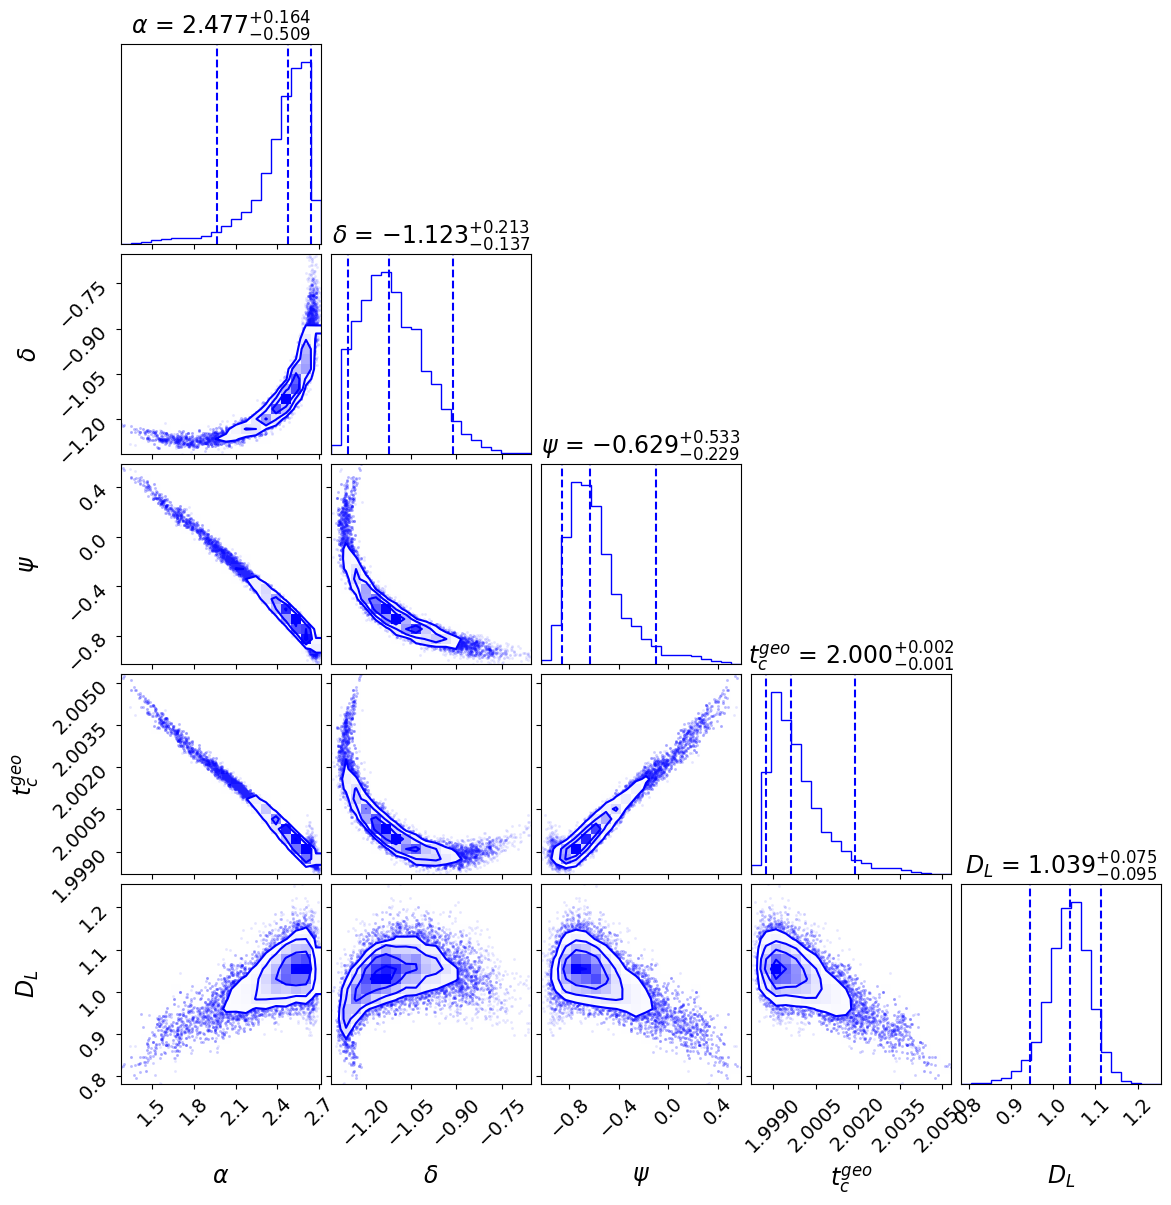

In [8]:
equal_samples = plot_corner(sampler, 'HL')

Most probable location: RA = 141.62 deg, Dec = -64.95 deg


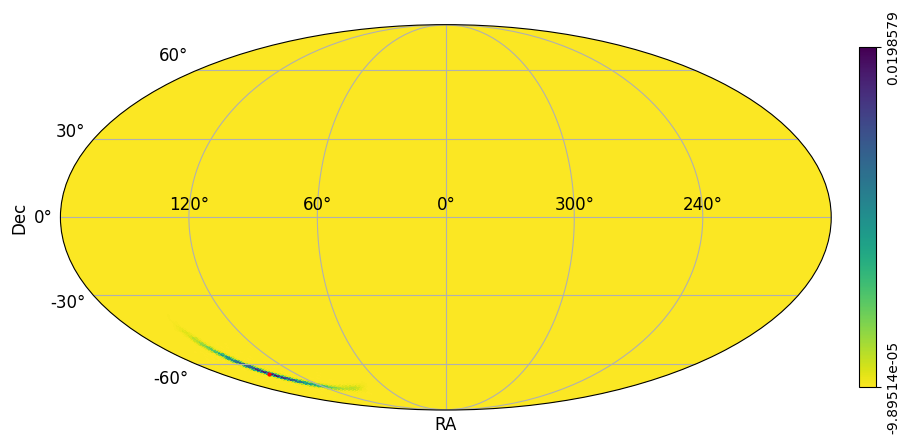

In [9]:
plot_map(equal_samples, 'HL')

In [10]:
IFOS = [IFOH, IFOL, IFOV]
strains = [data['h1_strain'], data['l1_strain'], data['v1_strain']]

sampler = dynesty.DynamicNestedSampler(
    log_likelihood,
    priors,
    ndim=5,
    nlive=1000,    
    bound="multi", 
    sample="rwalk",
    queue_size=multiprocessing.cpu_count(),
    pool=multiprocessing.Pool(processes=multiprocessing.cpu_count()),
    periodic=[0,2],
    rstate=np.random.default_rng(seed=441),
)
sampler.run_nested(dlogz_init=0.01, print_progress=True)

45137it [02:59, 251.61it/s, batch: 2 | bound: 3 | nc: 1 | ncall: 1033200 | eff(%):  4.269 | loglstar: -11917.486 < -11913.624 < -11916.859 | logz: -11948.403 +/-  0.156 | stop:  0.877]     


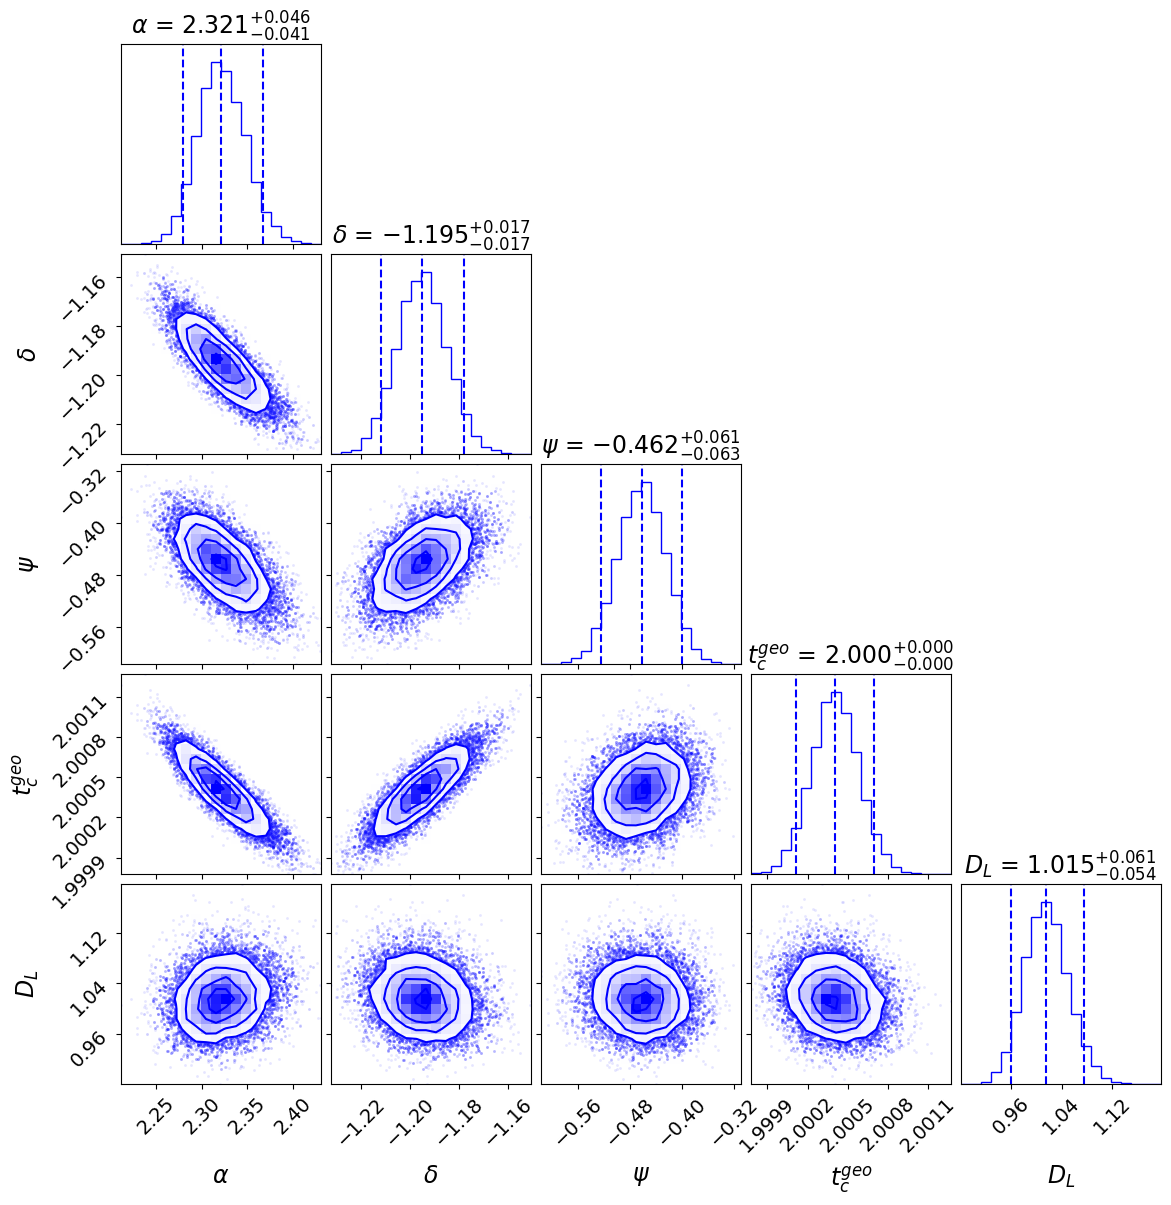

In [11]:
equal_samples = plot_corner(sampler, 'HLV')

Most probable location: RA = 131.90 deg, Dec = -68.68 deg


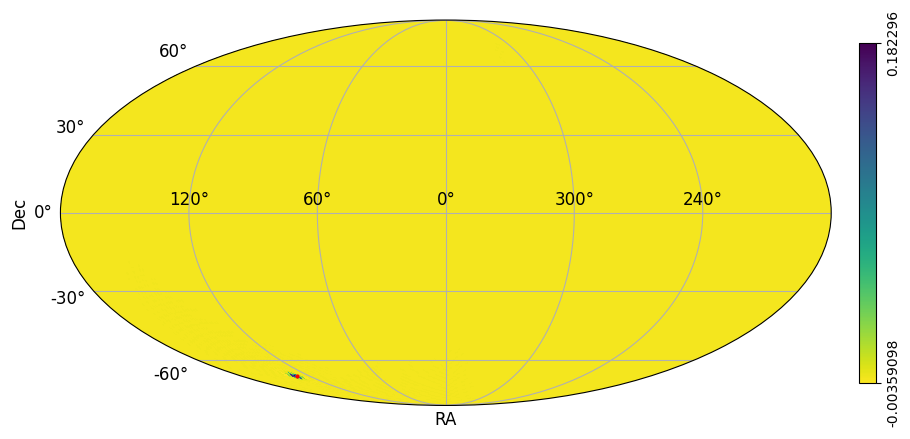

In [12]:
plot_map(equal_samples, 'HLV')